In [106]:
import pandas as pd
from sqlalchemy import create_engine, text
from IPython.display import display, HTML
import MySQLdb
import datetime
import re
import csv
import subprocess, os
from IPython.display import Image

In [2]:
# Create a connection to the database.
# This code creates a connection to the UMETRICS server. You need to have an SSH tunnel open for this to work.
# RFE : We are using both sqlalchemy and mysqldb. Need to be consistent and will be changed later.
def dbConnect():
    username = "cjones"
    password = "LCnKGB0*38!fD47GPmpl"
    hostname = "localhost"
    dbalchemy = create_engine("mysql+mysqldb://" +username+":"+password+"@"+hostname)
    dbmysql = MySQLdb.connect(user=username, passwd=password, host=hostname)
    return dbalchemy, dbmysql

## 1. Introduction
The aim of this project was to link individuals a well curated survey, Survey of Earned Doctorates (SED), to researchers in a new source of transaction data, UMETRICS using innovative machine learning techniques. This report presents the methodology and results of several different techniques employed to achieve the linkage. This paper provides a description of the methodology and an analysis of the resulting linkages, and recommends the best methodology. 


## 2. Data

Note: The input tables in the database are created in the Input Data for SED - Umetrics linking notebook. Please refer to that notebook if you need to create the input tables.

The analysis in this paper is based on two distinct data sources, SED and UMETRICS. The UMETRICS data are drawn from human resources and financial records from 9 universities across the United States. Transactional records for a total of 248,705 employees were provided by the universities. We exclude the 34,943 employees that have no name information associated leaving us with a final sample of 213,762 records. Out of the nine universitites, three universitites provided us with date of birth infomration.  Table 1 gives a breakdown of the number of employees by university. 
The SED data was first limited to 2000-2014, since the UMETRICS data does not have data beyond this range. A total of 68,716 records were included in the final sample. Table 2 provides a breakdown of data by university. 

The above two data sources were combined together to produce three analytical files. 
- Training Data: This data was produced by matching UMETRICS to SED data using Fellegi-Sunter algorithm to produce a training dataset for the random forest model.
  - Training data for initial random forest
  - Training data for final random forest
- Gold Standard data: A subset of the training data produced above was manually validated to serve as evaluation dataset for the different models.
- Data for random forest: Records between SED and UMETRICS were compared to produce a dataset that would be used by the random forest algorithm to produce matches.

The following sections go into details about the three datasets and how to create them.

### 2.1 Training Data

Random forests model requires a truth dataset that serves to train the model. Constructing a linked dataset to serve as training data is prohibitively expensive manually. We use the Fellegi-Sunter model (Fellegi & Sunter, 1969) and date of birth data from three universities to construct a training dataset. 



In [ ]:
def sedDOBinput(db):
    SED_INSTITUTIONS = {
        "243780": "Purdue",
        "174066": "UMN",
        "240444": "UWisconsin",
        "153658": "UIowa",
        "170976": "UMich",
        "151351": "UIndiana",
        "204796": "OSU",
        "214777": "PSU",
        "110404": "Caltech"
        }
    sed = ",".join(SED_INSTITUTIONS.keys())
    data = pd.read_sql("""select DRF_ID, NAMELAST, NAMFSTMI,
                        PHDCY, BIRTHMO, BIRTHYR, PHDINST from seddata.sed where PHDCY >= 2000
                        AND PHDINST in (""" + sed +");", db)
    firstword = re.compile(r"^\w+")
    with open(".\data\sed_names_dob.csv", "w") as f:
        wr = csv.writer(f, lineterminator="\n")

        for index, record in data.iterrows():
            key = record["NAMELAST"][0] if len(record["NAMELAST"]) > 0 else ""

            university = SED_INSTITUTIONS[record["PHDINST"]]
            seq = record["DRF_ID"]
            lastname = record["NAMELAST"]
            lastname = record["NAMELAST"]
            firstname = record["NAMFSTMI"]
            degree_year = record["PHDCY"]
            birth_month = record["BIRTHMO"]
            birth_year = record["BIRTHYR"]

            wr.writerow([key, university, seq, lastname, firstname, birth_month, birth_year, degree_year])
    

In [ ]:
def umetrics_matching_input_file_dob(db):
    data = pd.read_sql("""select left(names.last_name, 1), university, __employee_id,
                        names.last_name, names.first_name, month(dob) birth_month, 
                        year(dob) birth_year, ifnull(max_grad_year, year(max_period_end_date)) 
                        from air.sm_input_sed names where university in ('OSU', 'UWisconsin', 'Purdue');""", db)

    data.to_csv("./data/sm_names_dob.csv", header = False, index = False)

Now lets call the two functions to create our input files.

In [ ]:
os.chdir("G:/SED/")
umetrics_matching_input_file_dob(dbalchemy)
sedDOBinput(dbalchemy)

The table below provides the summary statistics for our input data to the Fellegi-Sunter model.


In [85]:
pd.options.display.max_colwidth = 2000
sed = pd.read_csv("./data/sed_names_dob.csv")
um = pd.read_csv("./data/sm_names_dob.csv")

display("Total number of SED records = " + str(len(sed.index)))
# Should be 59,558 in the intial run.

display("Total number of UMETRICS records = " + str(len(um.index)))
# Should be 73,156 in the initial run

df = pd.read_csv("./data/summary_dob.csv")
display(df.iloc[0:5, 0:4])

'Total number of SED records = 59557'

'Total number of UMETRICS records = 73155'

,Variables,Description,N Missing in SED,N Missing in UMETRICS
0,University,Name of the university. Used for blocking,0,0
1,Last Name,Last name of the individual in the two records.,2,0
2,First Name,First name of the individual in the two records.,1,5
3,Month of birth,Month in which individual was born,4337,0
4,Year of birth,Year in which individual was born.,3933,0


The next task is to define the levels of the comparisons between the four fields defined above. We use the jaro-winkler (Cohen et al, 2003) string metric to compare names. The table below defines the different levels that were created for each variable.

In [87]:
df2 = df.iloc[6:11, 0:3]
df2.columns = ["Variables", "Number of levels", "Description of levels"]
display(df2)

,Variables,Number of levels,Description of levels
6,University,Blocking field,Not applicable
7,Last Name,5,Jaro Winkler (jw) = 1 = Exact agreement; 1 > jw >= 0.92 = Strong agreement; 0.92 > jw >= 0.85 = Moderate Agreement; 0.85 > jw = Disagreement; Missing
8,First Name,5,Jaro Winkler (jw) = 1 = Exact agreement; 1 > jw >= 0.92 = Strong agreement; 0.92 > jw >= 0.85 = Moderate Agreement; 0.85 > jw = Disagreement; Missing
9,Month of birth,3,"Exact Match, Disagreement, Missing"
10,Year of Birth,3,"Exact Match, Disagreement, Missing"


The `first name` field in the SED is a variable named `NAMFSTMI` that concatenates first and middle name fields. All first name comparisons are based on two separate string comparisons: once using the first word of `NAMFSTMI` and once using the entire `NAMFSTMI`. The greater of the two Jaro-Winkler comparison values is used as the final first name comparison result.

We will now use the Fellegi-Sunter model to match these two files. We will be using the java implementation of the algorithm here: https://github.com/CSSIP-AIR/torchRL. We calculated the Bayesian posterior means of the parameters for this model via Markov Chain Monte Carol methods (Yancey, 2013).


In [ ]:
# Before running this code make sure that MatchDOB.java, ModelDOB.java and Model.java are compiled.
# and that java is in your path.

def initial_matching(directory, matching_program, CLASSPATH):
    subprocess.call(["java", "-cp", CLASSPATH, matching_program, directory])

In [ ]:
LIBDIR = r"G:\SED\Models\FS"
CLASSPATH = r".;G:\SED\Library\torch-1.0-SNAPSHOT.jar;" + LIBDIR
directory = r"G:\SED\data"
initial_matching(directory, "MatchDOB", CLASSPATH)

We limited the links to those sets that receieved an overall score > 0. In this model , the prediction of link status is made for each record pair independently of all other record pairs. This means that the same record in the SED may be predicted to link to multiple records in STAR METRICS and vice versa. For the purpose of statistical analysis, we assume that both data sets are perfectly disambiguated. This means that when multiple links are predicted at most one of them can be a true positive. Therefore, to create a final data set from an initial set of predicted links we apply a separate algorithm to extract an optimal set of one-to-one links. The approaches to record linkage that we are studying assign “match scores” to pairs of records – these are scalar values whose magnitude indicates the likelihood of a match. An optimal set of one-to-one links is one that maximizes the sum of match scores.

The following function calls the Java program that performs this one-to-one extraction.


In [ ]:
def extract_1x1_links(directory=SED_WORKING_DIR, assign_program="Assign"):
    subprocess.call(["java", "-cp", CLASSPATH, assign_program, directory])

The following table gives a distribution of links in the training data by scores. 

In [89]:
display("Total Number of records  = 108,059")
df3 = df.iloc[29:119, 0:2]
df3.columns = ["Score", "N"]
display(df3.head())
display(df3.tail())

'Total Number of records  = 108,059'

,Score,N
29,0.063061,2499
30,0.2028645,19009
31,0.2654752,39
32,0.3812334,50
33,0.5564919,26


,Score,N
112,13.27195,1
113,14.41776,1
114,14.55756,67
115,14.66444,79
116,14.80424,6010


#### 2.1.1Training data for initial random forest

A random forest offers a simple way to measure variable importance for each of its features, giving insights into the interaction between each feature and the prediction accuracy (Treeratpituk & Giles 2009). We started with a total of 37 variables. We computed the corresponding values for these 37 variables for the records in the training dataset. The following table gives the description of the variables we considered.

In [90]:
df = pd.read_csv("./initial random forest.csv")
display(df.iloc[:, 0:4])

,Variables,Source,Type,Description
0,first_full_jw,UMETRICS & SED,Continuous,Jaro-Winkler comparision value between first name in UMETRICS and NAMFSTMI in SED
1,first_jw,UMETRICS & SED,Continuous,Jaro-Winkler comparision value between first name in UMETRICS and first word of NAMFSTMI in SED
2,last_jw,UMETRICS & SED,Continuous,Jaro-Winkler comparison of last name in UMETRICS and NAMELAST in SED
3,PHDCY_minus_max_grad_year,UMETRICS & SED,Continuous,Difference between PHDCY in SED and max_grad_year in UMETRICS in years
4,PHDFY_minus_max_grad_year,UMETRICS & SED,Continuous,Difference between PHDFY in SED and max_grad_year in UMETRICS in years
5,PHDCY_minus_max_year,UMETRICS & SED,Continuous,Difference between PHDFY in SED and max_year (last year researcher appeared in UMETRICS data) in UMETRICS in years
6,middle_init,UMETRICS & SED,Categorical,Binary indicating exact agreement between middle initial in SED and UMETRICS data
7,PHDFY_minus_max_year,UMETRICS & SED,Continuous,Difference between PHDFY in SED and max_year (last year researcher appeared in UMETRICS data) in UMETRICS in years
8,middle_jw,UMETRICS & SED,Continuous,Jaro-Winkler comparison of middle name in UMETRICS and everything following the first word of NAMFSTMI in SED
9,last_name_freq_umetrics,UMETRICS,Continuous,Frequency of the UMETRICS last name


#### 2.1.2 Training Data for Final Random Forest Model

Based on the results of the initial random forest model, we chose a final sample of 19 variables to include in our final random forest models. The table below provides a description of the variables.

In [104]:
df = pd.read_csv("./final random forest.csv")
display(df.iloc[:, 0:4])

,Source,Type of variable,Variables,Description
0,UMETRICS & SED,Continuous,"max(first_jw, first_full_jw)","larger value bewteen Jaro-Winkler comparison of first name in UMETRICS and first word of NAMFSTMI in SED, and Jaro-Winkler comparison of first name in UMETRICS and NAMFSTMI in SED"
1,UMETRICS,Continuous,first_name_freq_umetrics,Frequency of the UMETRICS first name
2,SED,Continuous,first_name_freq_sed,Frequency of the first word of NAMFSTMI
3,UMETRICS & SED,Continuous,last_jw,Jaro-Winkler comparison of last name in UMETRICS and NAMELAST in SED
4,UMETRICS,Continuous,last_name_freq_umetrics,Frequency of the UMETRICS last name
5,SED,Continuous,last_name_freq_sed,Frequency of NAMELAST
6,UMETRICS & SED,Continuous,middle_jw,Jaro-Winkler comparison of middle name in UMETRICS and everything following the first word of NAMFSTMI in SED
7,SED,categorical-dummy,SRCEPRIM=ABDF,"SRCEPRIM is one of A, B, D, or F"
8,SED,categorical-dummy,SRCEPRIM=GHIJKL,"SRCEPRIM is one of G, H, I, J, K, or L"
9,SED,categorical-dummy,SRCEPRIM=missing,SRCEPRIM is missing


The table below provides descriptive statistics for the independent variables in the training dataset.

In [102]:
df = pd.read_csv("./final random forest.csv")
df.head()
display(df[["Variables", "N", "Mean", "SD", "Minimum", "Maximum"]])

,Variables,N,Mean,SD,Minimum,Maximum
0,"max(first_jw, first_full_jw)",14882,0.845118,0.270149,0.000000,1.000000
1,first_name_freq_umetrics,14882,0.002782,0.003873,0.000001,0.014103
2,first_name_freq_sed,14882,0.002786,0.003892,0.000001,0.014103
3,last_jw,14882,0.708375,0.348538,0.000000,1.000000
4,last_name_freq_umetrics,14882,0.001070,0.002187,0.000001,0.008211
5,last_name_freq_sed,14882,0.001099,0.002210,0.000001,0.008211
6,middle_jw,14882,0.375301,0.303509,0.000000,1.000000
7,SRCEPRIM=ABDF,14882,0.526206,0.499329,0.000000,1.000000
8,SRCEPRIM=GHIJKL,14882,0.069144,0.253707,0.000000,1.000000
9,SRCEPRIM=missing,14882,0.215159,0.410947,0.000000,1.000000


#### 2.1.3 Missing values

Random forest models are not designed to deal with missing values. WE used the following rules to impute missing values for variables

- max_grad_year: If missing, the last year in which the researcher appeared in the UMETRICS data was taken.
- max(first_jw, first_full_jw): If the first name was missing in either UMETRICS or SED, 1 (the maximum jaro-winkler value denoting disagreement) was used.
- first_name_freq_umetrics: If first name was missing in UMETRICS, 0 was used.
- first_name_freq_sed: If first name was missing in SED, 0 was used.
- last_jw: If the last name was missing in either UMETRICS or SED, 1 (the maximum jaro-winkler value denoting disagreement) was used
- last_name_freq_umetrics: If last name was missing in UMETRICS, 0 was used.
- last_name_freq_sed: If last name was missing in SED, 0 was used.
- middle_jw: If the middle name was missing in either UMETRICS or SED, 1 (the maximum jaro-winkler value denoting disagreement) was used.
- SRCEPRIM=ABDF: Missing values, if any, were coded as 0.
- SRCE_count: No missing values.
- PHDFIELD=Science: Missing values were coded as 0
- PHDFIELD=Health: Missing values were coded as 0
- PHDFIELD=Psychology: Missing values were coded as 0
- TUITREMS=4: Missing values were coded as 0
- PHDCY~ ~Ustart: No missing values
- PHDCY=max_grad_year: No missing values, since we already dealt with missing max_grad_days and there are no missing PHDCY values.
- PHDCY~ ~max_grad_year: No missing values, since we already dealt with missing max_grad_days and there are no missing PHDCY values.
- days_worked_as_grad: If missing, the days that the total number of days the researcher appeared in the UMETRICS data used.

### 2.2 Gold Standard Dataset

We now had a set of records that would act as training dataset for the random forests model. However, this dataset, by itself, cannot be used to evaluate the random forests model, since it has not been manually reviewed. For evaluation purposes, we need to create a gold standard dataset.

A gold standard dataset was created from a sample of the training dataset created above before running it through the one-to-one link extraction program.  The pseudo-validated data had 108,719 records in total. The scores ranged from [0.02761, 14.800]. A sample of 660 records in total was obtained after grouping the data using score and PHD calendar year. The table below describes the sample:

In [88]:
df3 = df.iloc[12:26, 0:5]
df3.columns = ["Score", "PHD Calendar Year", "N", "Sampling Rate", "Sample size"]
display(df3)

,Score,PHD Calendar Year,N,Sampling Rate,Sample size
12,[14-15),2000-2005,547,0.03,16
13,,2006-2012,5801,0.03,174
14,"[10, 14)",2000-2005,13,0.38,5
15,,2006-2012,131,0.15,20
16,[8-10),2000-2005,26,0.20,5
17,,2006-2012,543,0.20,109
18,"[7,8)",2000-2005,38,0.20,8
19,,2006-2012,193,0.20,39
20,"[6,7)",2000-2005,617,0.10,62
21,,2006-2012,1569,0.10,157


This sample was reviewed manually by researchers and a true status of 659 links was established. The true status of 1 links was undetermined since there is no birth information available in the SED data. That link is excluded from the gold standard dataset. We then excluded these links from the training dataset we created above to avoid overfitting and produce an accurate error estimate.


## 3. Methodology

### 3.1 Feature Selection (Treeratpituk & Giles, 2009)
 
To select our final variables, we choose to look at the Gini importance and permutation importance of each variable. Gini importance is calculated using the Gini Index defined as:
$$I_G(i) = \sum_{j=1}^{K}{p_j(1-p_j)} = 1 - \sum_{j=1}^{K}(p_j^2)$$

where pj is the proportion of instances of class j in the node i, and K is the number of classes. IG(i) is minimum (= 0)when the node is pure. At each split, the variable that yields the biggest reduction in Gini index is selected. Then, Gini importance of a variable can be measures as the mean of the Gini decreases for that variable over all trees in the forest.

To compute the permutation accuracy importance of a variable X<sub>i</sub>, for each tree that contains variable  X<sub>i</sub>, first randomly permute the feature X<sub>i</sub> in its out-of-bag data and then calculate the new OOB accuracy for this permuted input compared with its original OOB accuracy. Then, the variable importance of Xi is this decrease in accuracy averaged over all trees that contains  X<sub>i</sub>.


### 3.2 Model

Random forest is an ensemble classifier proposed by Breiman (Breiman 2001). At its core, a random forest combines a collection of decision trees, where each tree within the forest is built with a different bootstrap sample drawn the original dataset. For each split of the tree, variable selection is done using a random subset of features. Once the forest is complete, the classification is done by simply counting the votes of all trees. (Treeratpituk & Giles, 2009). We ran four different random forest models. The initial random forest included all variables that 
Based on the training data we generated above and the predictor variables we chose, we ran three different random forest models. Rather than train a 2-class model to predict links and non-links, we chose to train a 5-class model. This is because the statistical properties of clear links and non-links are different from the properties of links near the cutoff threshold. More specifically, comparisons between clear links will show exact agreement in all fields and comparisons between clear nonlinks will show complete disagreement. The difference in the three models was how the different thresholds were defined. The table below defines the different thresholds used for training the model.

| Model 1 | Model 2 | Model 3 | Class | Type | Notes         
| :- |-------------: | :-:
|>= 14.0 |  = 14.8 | =14.8 | 4 | Match | All links are written
|[8.2, 14) |  [8.2, 14.8) | [10.0, 14.8) | 3 | Match | 2345
|[6.0, 8.2) |  [6.0, 8.2) | [6.0, 10.0) | 2 | Non Match | 2345
|[0.0, 6.0) |  [0.0, 6.0) | [0.0, 6.0) | 1 | Non Match | 2345
|All records |  All records | All records | 0 | Non Match | 2345

The random forest model gave a probability to each class for each record. We them summed up the probabilites for classes 3 and 4 to obtain the total probability of the record being a match.

### 3.3 Evaluation Methodology

We use the following five measures to evaluate our models.

Precision meaxures the false match rates within a set of pairs. It is defined as:
$$Precision= \dfrac{Number of true positives}{Number of of true positives + Number of false  positives}$$


Estimating the proportion of false nonmatches is called recall, and is measured as
$$Recall= \dfrac{Number of true positives}{Number of true positives+ Number of false negatives}$$

A statistical way in which these approaches can be compared is provided by an F-score.

$$F-Score = \frac{2.Precision.Recall}{Precision + Recall}$$

Accuracy is the ratio of the total number of correct classifications to the total number of classifications.

$$Accuracy = \frac{True Positives + True Negatives}{True Positives + True Negatives + False Positives + False Negatives}$$

Area under the ROC curve (AUC) is calculated using the trapezoidal rule. The R package `pROC` is used for this compuation (Jill and Hand, 2001).

## 4. Results

First we compute the Gini and permutation importance using the 37 variables in our initial random forest model in Section 6.1. Next, we evaulate the linkage results of three different random forest models in Section 6.2. 



### 4.1 Feature Selection

The table below gives the permutation importance and mean decrease in Gini for our initial variables.

In [105]:
df = pd.read_csv("./initial random forest.csv")
display(df[["Variables", "MeanDecreaseAccuracy", "MeanDecreaseGini" ]])

,Variables,MeanDecreaseAccuracy,MeanDecreaseGini
0,first_full_jw,0.053063,3091.531221
1,first_jw,0.051959,2652.725027
2,last_jw,0.069021,2289.185323
3,PHDCY_minus_max_grad_year,0.012506,459.044080
4,PHDFY_minus_max_grad_year,0.009229,359.725255
5,PHDCY_minus_max_year,0.005412,328.699566
6,middle_init,0.002038,298.919627
7,PHDFY_minus_max_year,0.005964,222.860527
8,middle_jw,0.000832,172.093599
9,last_name_freq_umetrics,0.002891,111.908428


From the table above, it is clear that first and last name are the most important variables in linking. Similarly, both the calendar year of PHD grant date and the max_grad_year are important predictors. The frequency of the first and last names as well as the middle names provide important information.

### 4.2 Evaluation

The table below gives the evaluation results of the three models based on the final cutoff we chose for the model. The cutoffs range from 0.2 to 1, with indicating the highest match score possible. 

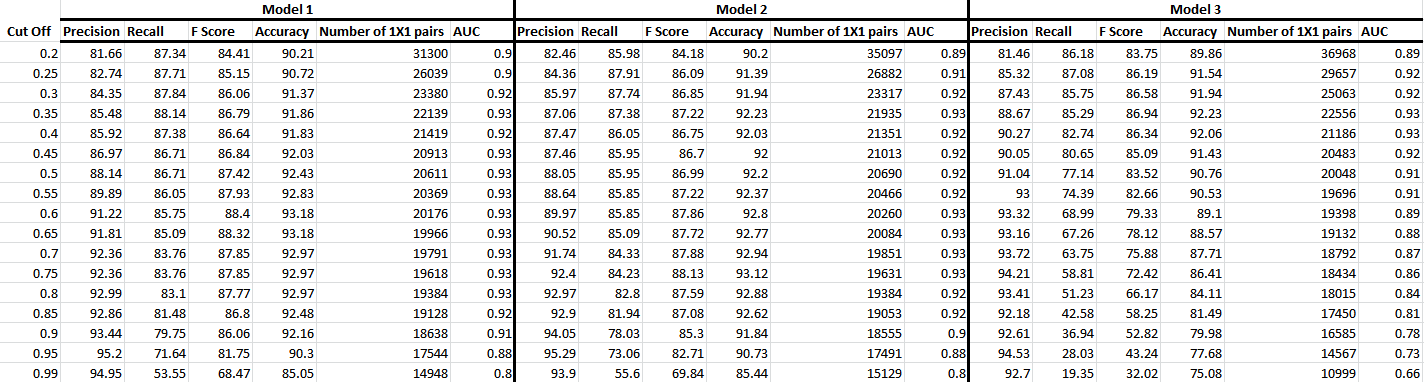

In [107]:
Image(filename='G:/SED/evals.png') 

Model 1 gives the best results. The above table also highlights that the threshold choice for the model depends on what the research question is. Our tolerance for false negatives and false positives will determine what threshold we want to choose as the final set of links.

## References
* Breiman, Leo. "Random forests." Machine learning 45.1 (2001): 5-32.

* Treeratpituk, Pucktada, and C. Lee Giles. "Disambiguating authors in academic publications using random forests." Proceedings of the 9th ACM/IEEE-CS joint conference on Digital libraries. ACM, 2009.

* Fellegi, Ivan P., and Alan B. Sunter. "A theory for record linkage." Journal of the American Statistical Association 64.328 (1969): 1183-1210.

* Cohen, William, Pradeep Ravikumar, and Stephen Fienberg. "A comparison of string metrics for matching names and records." Kdd workshop on data cleaning and object consolidation. Vol. 3. 2003.

* Tom Fawcett (2006) “An introduction to ROC analysis”.Pattern Recognition Letters 27, 861–874. DOI: 10.1016/j.patrec.2005.10.010

* David J. Hand and Robert J. Till (2001).   A Simple Generalisation of the Area Under the ROC Curve for Multiple Class Classification Problems. Machine Learning 45 (2),  p.  171–186.  DOI: 10.1023/A:1010920819831